In [5]:
import pandas as pd
from glob import glob
from matplotlib import pyplot as plt
import os
from tqdm import tqdm

all_df = []
for f in tqdm(glob("data/lyft*.tar.gz")):
    df = pd.read_csv(f)
    df = df[df.type=="electric_scooter"][["bike_id","lat","lon","is_disabled"]]
    df["timestamp"] = pd.to_datetime(os.path.basename(f).split(".")[0].split("_")[-1])
    all_df.append(df[["timestamp","bike_id","lat","lon","is_disabled"]])
all_df_lyft = pd.concat(all_df)
all_df_lyft["provider"] = 0
print("Lyft", len(all_df_lyft.bike_id.unique()))

all_df = []
for f in tqdm(glob("data/spin*.tar.gz")):
    df = pd.read_csv(f, usecols=['bike_id', 'lat', 'lon', 'is_disabled',
        'vehicle_type_id'] )
    df = df[df.vehicle_type_id == 1] # scooters
    df["timestamp"] = pd.to_datetime(os.path.basename(f).split(".")[0].split("_")[-1])
    all_df.append(df[["timestamp","bike_id","lat","lon","is_disabled"]])
all_df_spin = pd.concat(all_df)
all_df_spin["provider"] = 1
print("Spin", len(all_df_spin.bike_id.unique()))

all_df = []
for f in tqdm(glob("data/Link*.tar.gz")):
    df = pd.read_csv(f)[["bike_id","lat","lon","is_disabled"]]
    df["timestamp"] = pd.to_datetime(os.path.basename(f).split(".")[0].split("_")[-1])
    all_df.append(df[["timestamp","bike_id","lat","lon","is_disabled"]])
all_df_link = pd.concat(all_df)
all_df_link["provider"] = 2
print("Link", len(all_df_link.bike_id.unique()))

scooters = pd.concat([all_df_lyft, all_df_spin, all_df_link]).sort_values(by="timestamp")

split_by_date = []
for date, day_df in scooters.groupby(pd.Grouper(key='timestamp', freq='D')):
    split_by_date.append([date, day_df])
    
for i in split_by_date[:-1]:
    filename = str(i[0].date())+".tar.gz"
    print(filename, len(i[1]))
    i[1].to_csv("clean/"+filename)
    
for f in glob("data/**/*.tar.gz", recursive=True):
    for i in split_by_date[:-1]:
        filename = str(i[0].date())
        if filename in f:
            os.remove(f)

  0%|          | 0/17009 [00:00<?, ?it/s]

Lyft 79279


100%|██████████| 17009/17009 [05:14<00:00, 54.08it/s]


Spin 6074


100%|██████████| 8505/8505 [02:17<00:00, 62.03it/s]


Link 2976


2022-03-02.tar.gz 666713
2022-03-03.tar.gz 6049908
2022-03-04.tar.gz 5084866
2022-03-05.tar.gz 0
2022-03-06.tar.gz 0
2022-03-07.tar.gz 1422947
2022-03-08.tar.gz 3703459


In [183]:
aday_scooters.drop_duplicates(subset=["bike_id"], keep="first").groupby("provider").count()

,timestamp,bike_id,lat,lon,is_disabled
provider,,,,,
0,23476,23476,23476,23476,23476
1,2398,2398,2398,2398,2398
2,1181,1181,1181,1181,1181


In [185]:
x = aday_scooters.drop_duplicates(subset=["bike_id"], keep="first")

In [187]:
x.timestamp.min()

Timestamp('2022-03-03 00:00:06')

In [188]:
x.timestamp.max()

Timestamp('2022-03-03 23:59:58')

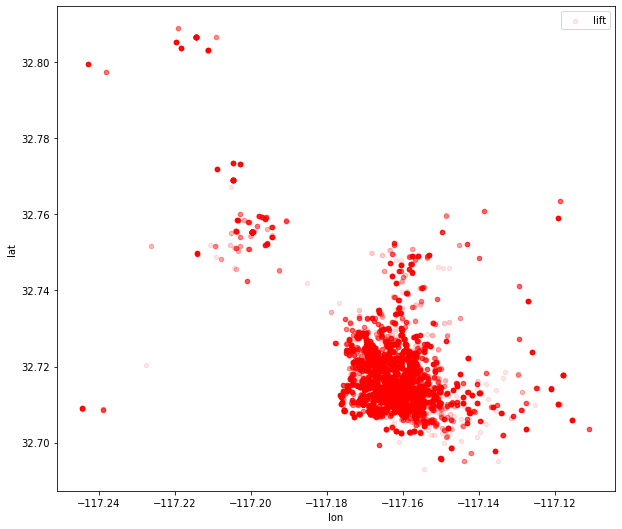

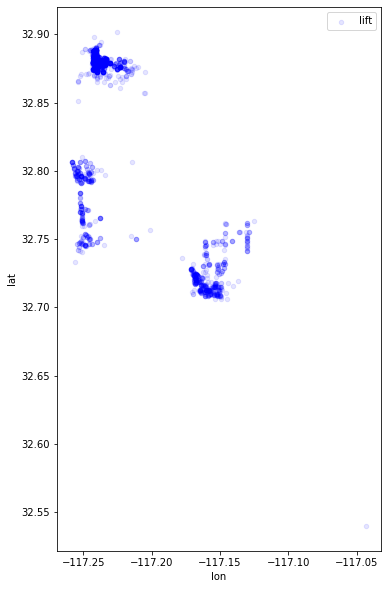

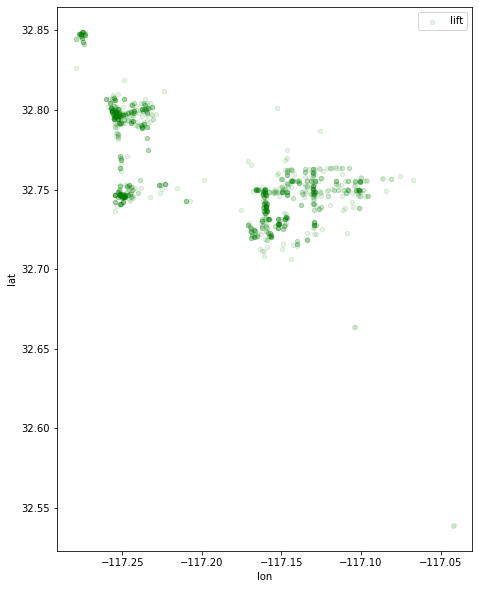

In [179]:
c = ["red","blue","green"]
l = ["lift","spin","link"]
for i in range(0,3):
    f = plt.figure(figsize=[10,10])
    ax = f.gca()
    ax.set_aspect('equal', adjustable='box')
    x[x.provider==i].plot.scatter(x="lon",y="lat", ax=ax, label="lift", c=c[i], alpha=0.1)


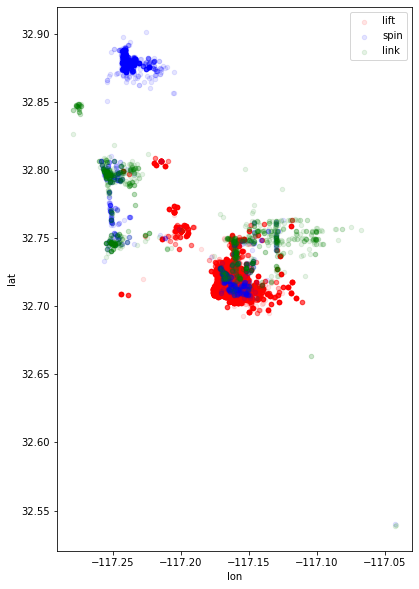

In [189]:
f = plt.figure(figsize=[10,10])
ax = f.gca()
c = ["red","blue","green"]
l = ["lift","spin","link"]
for i in range(0,3):
    ax.set_aspect('equal', adjustable='box')
    x[x.provider==i].plot.scatter(x="lon",y="lat", ax=ax, label=l[i], c=c[i], alpha=0.1)

In [ ]:
# scooters to image

KeyboardInterrupt: 

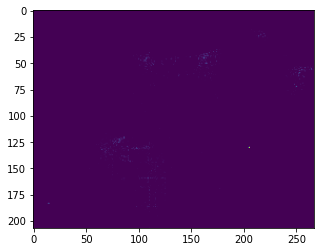

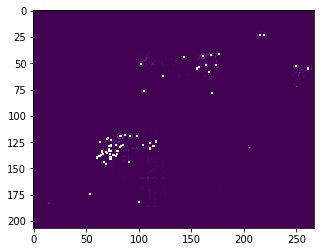

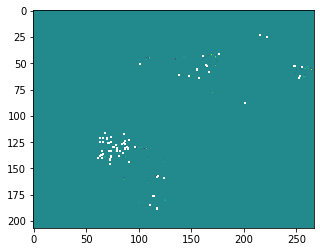

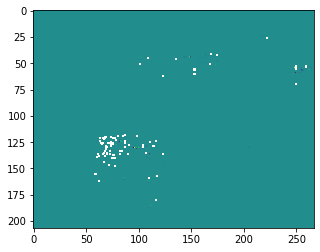

In [124]:
prev_xdf = 0
for i, hdf in df.groupby(pd.Grouper(freq="300S",  key="timestamp")):
    grid, nhdf = add_cell_id(hdf, 100, bounds=bounds, latitude="lat", longitude="lon", crs=crs_4326, projected=False)
    xdf = nhdf.groupby("cell_id")["bike_id"].count()
    delta = xdf-prev_xdf
    prev_xdf = xdf
    limage = []
    for i, row in delta.reset_index().iterrows():
        limage.append([row["cell_id"][0],row["cell_id"][1],row["bike_id"]])

    image = pd.DataFrame(limage, columns=["x","y","value"])
    max_x = image.x.max()
    max_y = image.y.max()

    img =  np.zeros([max_x+1,max_y+1])
    for l in limage:
        img[l[0]][l[1]] = l[2]
    plt.figure()
    plt.imshow(img)
    break

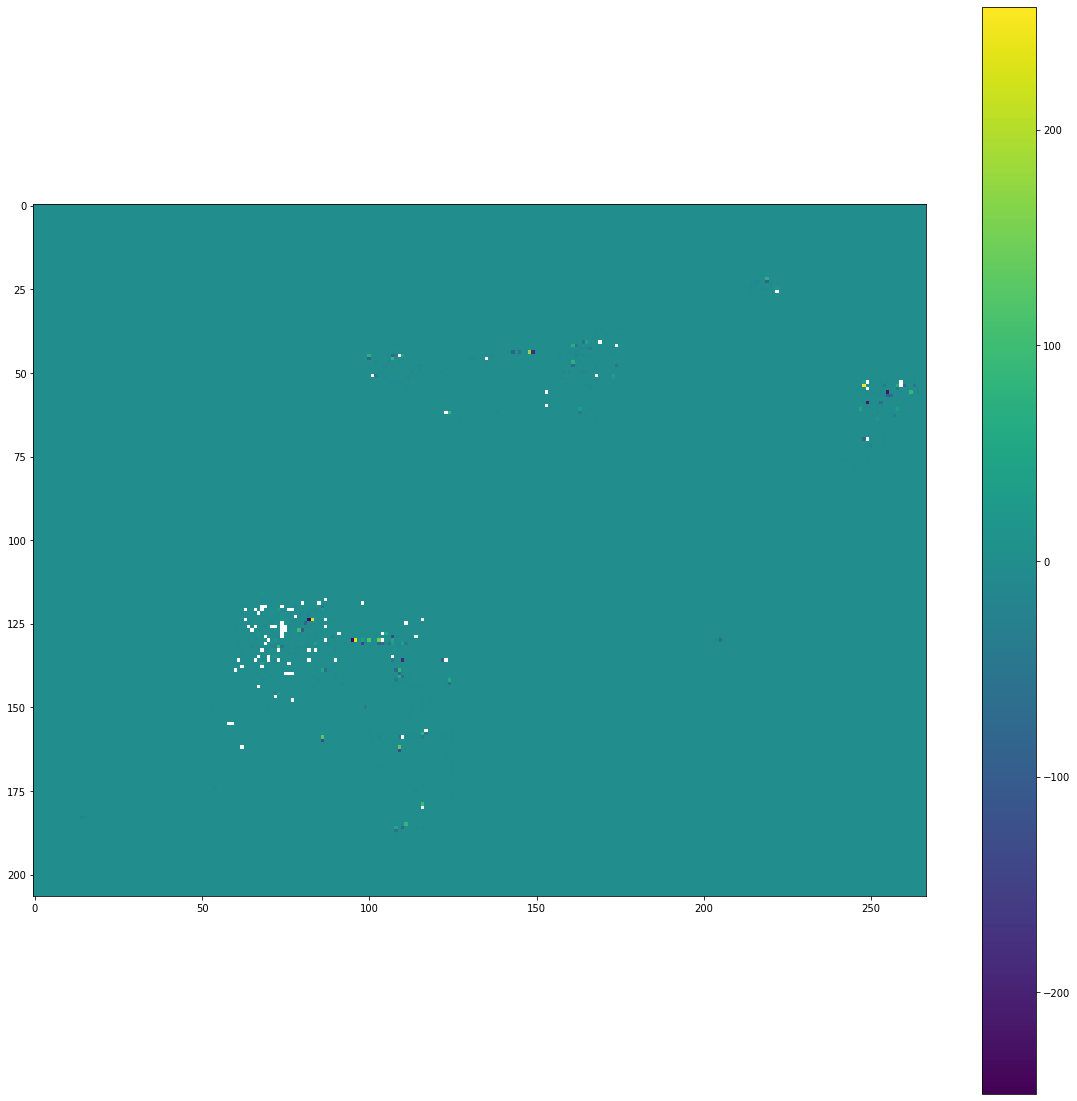

In [133]:
plt.figure(figsize=[20,20])
plt.imshow(img)
plt.colorbar()

In [ ]:
choropleth(df, grid_size=1000, cmap="plasma", 
           latitude="lat", bounds=bounds,
           longitude="lon", tiles='cartodb_positron', 
           column="bike_id", crs=crs_4326, figsize=[10,10])

In [110]:
# vectorized haversine function
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1 = np.radians(lat1)
        lon1 = np.radians(lon1)
        lat2 = np.radians(lat2)
        lon2 = np.radians(lon2)

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [113]:
for i,f in df.groupby("bike_id"):
    if len(f) > 2:
        f['dist'] = haversine(f.lat.shift(), f.lon.shift(), df.loc[1:, 'lat'], df.loc[1:, 'lon'])
        if len(f[f['dist'] > 1]):
            break

In [114]:
f

,Unnamed: 0,timestamp,bike_id,lat,lon,is_disabled,provider,geometry,dist
2403,1308,2022-03-08 08:51:55,015e283d-2c95-4eca-8ae7-55c4f04f58c3,32.756380,-117.132570,0,2,POINT (-117.13257 32.75638),NaN
3530,1307,2022-03-08 08:52:30,015e283d-2c95-4eca-8ae7-55c4f04f58c3,32.756380,-117.132570,0,2,POINT (-117.13257 32.75638),0.000000
5933,1307,2022-03-08 08:53:04,015e283d-2c95-4eca-8ae7-55c4f04f58c3,32.756380,-117.132570,0,2,POINT (-117.13257 32.75638),0.000000
8521,1307,2022-03-08 08:53:39,015e283d-2c95-4eca-8ae7-55c4f04f58c3,32.756380,-117.132570,0,2,POINT (-117.13257 32.75638),0.000000
12096,1306,2022-03-08 08:54:14,015e283d-2c95-4eca-8ae7-55c4f04f58c3,32.756380,-117.132570,0,2,POINT (-117.13257 32.75638),0.000000
...,...,...,...,...,...,...,...,...,...
1690892,1274,2022-03-08 15:39:20,015e283d-2c95-4eca-8ae7-55c4f04f58c3,32.756390,-117.132600,0,2,POINT (-117.13260 32.75639),0.000000
1694260,1274,2022-03-08 15:39:55,015e283d-2c95-4eca-8ae7-55c4f04f58c3,32.756390,-117.132600,0,2,POINT (-117.13260 32.75639),0.000000
1696260,1273,2022-03-08 15:40:30,015e283d-2c95-4eca-8ae7-55c4f04f58c3,32.756390,-117.132600,0,2,POINT (-117.13260 32.75639),0.000000
1698291,1273,2022-03-08 15:41:05,015e283d-2c95-4eca-8ae7-55c4f04f58c3,32.756413,-117.132606,0,2,POINT (-117.13261 32.75641),0.002576


In [103]:
f[f.dist>0]

,Unnamed: 0,timestamp,bike_id,lat,lon,is_disabled,provider,geometry,dist
